# Analytical Sigmoid-Based Coordinate Warping

## 🎯 Project: Adaptive Coordinate Warping for Multi-Modal Optimization

This notebook implements **sigmoid-based coordinate compression** for escaping local optima.

### Core Concept:

**Integer nodes on infinite domain**: ..., -2, -1, 0, 1, 2, ..., ∞

**Compression specification**: `(node_index, length)`
- `node_index`: Starting node to compress
- `length`: Distance/length to compress (NOT number of nodes!)

**Example**:
- `(20, 1)`: No compression - node 20 to node 21 (length=1, 2 nodes total)
- `(20, 10)`: Compress from node 20 to node 30 (length=10, **11 nodes total**)
  - Nodes to compress: 20, 21, 22, ..., 30 (11 nodes)
  - Compressed into interval [20, 21] (unit length)
  - **Boundary nodes fixed**: Node 20 → 20.0, Node 30 → 21.0
  - **Inner nodes** (21-29): Use sigmoid for smooth distribution
  - Nodes after 30 shift left by 9 units

**Sigmoid mapping**:
- Boundary nodes: Fixed at endpoints (0 and 1)
- Inner nodes: Sigmoid distributes them smoothly between boundaries
- Reversible: can recover exact integer node from compressed position

---

## 📋 Implementation Plan:

1. **Metadata structure**: Store compression info
2. **Forward mapping**: Integer node → Compressed position (float)
3. **Inverse mapping**: Compressed position (float) → Exact integer node
4. **Visualization**: Show compression effect
5. **Testing**: Verify reversibility


In [36]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid  # sigmoid(x) = 1/(1+exp(-x))
from scipy.special import logit              # logit(p) = log(p/(1-p)), inverse of sigmoid

print("✅ Imports loaded!")
print(f"   NumPy: {np.__version__}")
print(f"   Matplotlib: {plt.matplotlib.__version__}")


✅ Imports loaded!
   NumPy: 2.0.1
   Matplotlib: 3.10.6


In [37]:
# Sigmoid-Based Coordinate Warping Class

class SigmoidWarping:
    """
    Sigmoid-based coordinate compression for infinite integer domain.
    
    Compresses 'length' consecutive nodes starting at 'node_index' 
    into a unit interval using smooth sigmoid transformation.
    """
    
    def __init__(self, node_index, length, steepness=5.0):
        """
        Parameters:
        -----------
        node_index : int
            Starting node to compress (e.g., 20)
        length : int
            Length/distance to compress (e.g., 10 means from node 20 to node 30)
            Total nodes = length + 1 (e.g., 11 nodes: 20, 21, ..., 30)
        steepness : float
            Sigmoid steepness parameter (higher = more linear, lower = more S-shaped)
        """
        self.node_start = int(node_index)
        self.length = int(length)
        self.node_end = self.node_start + self.length  # Inclusive end (e.g., 20 + 10 = 30)
        self.num_nodes = self.length + 1  # Total nodes (e.g., 11 nodes from 20 to 30)
        self.steepness = steepness
        
        # Compression amount: original length minus compressed length (1.0)
        self.shift = self.length - 1  # How much nodes after compression shift left
        
        print(f"📊 Sigmoid Warping Created:")
        print(f"   Start node: {self.node_start}")
        print(f"   End node: {self.node_end}")
        print(f"   Length: {self.length} (distance from {self.node_start} to {self.node_end})")
        print(f"   Total nodes: {self.num_nodes} nodes [{self.node_start}, {self.node_start + 1}, ..., {self.node_end}]")
        print(f"   Compressed to: [{self.node_start}, {self.node_start + 1}] (unit length)")
        print(f"   Boundary fixed: node {self.node_start} → {float(self.node_start)}, node {self.node_end} → {float(self.node_start + 1)}")
        print(f"   Inner nodes ({self.num_nodes - 2} nodes): Sigmoid mapping")
        print(f"   Nodes after {self.node_end}: Shift left by {self.shift} units")
        print(f"   Steepness: {steepness}")
    
    def forward(self, node):
        """
        Map integer node to compressed position (float).
        
        Parameters:
        -----------
        node : int or array of ints
            Integer node index(es)
        
        Returns:
        --------
        position : float or array of floats
            Compressed position(s)
        """
        node = np.atleast_1d(node)
        position = np.zeros(len(node), dtype=float)
        
        for i, n in enumerate(node):
            if n < self.node_start:
                # Before compression region: identity mapping
                position[i] = float(n)
            
            elif n > self.node_end:
                # After compression region: shifted identity
                position[i] = float(n) - self.shift
            
            else:
                # Inside compression region: sigmoid mapping
                # Boundary nodes are FIXED at 0 and 1
                if n == self.node_start:
                    # Left boundary: maps to position node_start (sigmoid = 0)
                    position[i] = float(self.node_start)
                elif n == self.node_end:
                    # Right boundary: maps to position node_start + 1 (sigmoid = 1)
                    position[i] = float(self.node_start + 1)
                else:
                    # Inner nodes: use sigmoid mapping
                    # Normalize to [0, 1] relative to boundaries
                    t = (n - self.node_start) / self.length
                    
                    # Apply sigmoid centered at 0.5
                    # Transform to smooth S-curve between 0 and 1
                    x = self.steepness * (t - 0.5)
                    sigmoid_t = sigmoid(x)
                    
                    # Map to target interval [node_start, node_start + 1]
                    position[i] = self.node_start + sigmoid_t
        
        return position[0] if np.isscalar(node) or len(node) == 1 else position
    
    def inverse(self, position):
        """
        Map compressed position (float) to exact integer node.
        
        Parameters:
        -----------
        position : float or array of floats
            Compressed position(s)
        
        Returns:
        --------
        node : int or array of ints
            Exact integer node(s)
        """
        position = np.atleast_1d(position)
        node = np.zeros(len(position), dtype=int)
        
        for i, pos in enumerate(position):
            if pos < self.node_start:
                # Before compression: inverse identity
                node[i] = int(round(pos))
            
            elif pos >= self.node_start + 1.0:
                # After compression: inverse shifted identity
                node[i] = int(round(pos + self.shift))
            
            else:
                # Inside compression region: inverse sigmoid
                # Normalize position to [0, 1]
                sigmoid_t = pos - self.node_start
                
                # Clamp to valid range
                sigmoid_t = np.clip(sigmoid_t, 0.0, 1.0)
                
                # Check for boundary cases
                if sigmoid_t <= 0.01:  # Near left boundary
                    node[i] = self.node_start
                elif sigmoid_t >= 0.99:  # Near right boundary
                    node[i] = self.node_end
                else:
                    # Inverse sigmoid (logit) for inner nodes
                    x = logit(sigmoid_t)  # Inverse of sigmoid
                    t = x / self.steepness + 0.5
                    
                    # Map back to node index
                    node_float = self.node_start + t * self.length
                    node[i] = int(round(node_float))
        
        return node[0] if np.isscalar(position) or len(node) == 1 else node
    
    def get_info(self):
        """Return compression metadata as dictionary."""
        return {
            'node_start': self.node_start,
            'node_end': self.node_end,
            'length': self.length,
            'shift': self.shift,
            'steepness': self.steepness,
            'compressed_interval': (self.node_start, self.node_start + 1.0)
        }


print("✅ SigmoidWarping class defined!")


✅ SigmoidWarping class defined!


### 🔑 KEY CONCEPT: Fixed Boundaries

**Important**: When compressing nodes [20, ..., 30]:

```
Node 20 (left boundary)  → Position 20.0  (sigmoid value = 0)  ← FIXED
Node 21 (inner)          → Position ~20.1  (sigmoid value ~0.1)
Node 22 (inner)          → Position ~20.2  (sigmoid value ~0.2)
...
Node 29 (inner)          → Position ~20.9  (sigmoid value ~0.9)
Node 30 (right boundary) → Position 21.0  (sigmoid value = 1)  ← FIXED
```

**Why this matters**:
- Boundary nodes stay at exact positions (no interpolation error)
- Only inner nodes use sigmoid (smooth distribution)
- This ensures perfect alignment at boundaries!


## 🧪 Example 1: Your Specific Case (Node 20, Length 10)


In [38]:
# Example 1: Compress nodes from 20 to 30 (length 10)
print("="*80)
print("EXAMPLE 1: Compress nodes [20, 21, ..., 30] (11 nodes) into interval [20, 21]")
print("="*80)

# Create warping with metadata: (node_index=20, length=10)
# This means: from node 20 to node 30 (length = 30-20 = 10)
warping = SigmoidWarping(node_index=20, length=10, steepness=5.0)

print("\n📊 Testing forward mapping (Node → Position):\n")
print(f"{'Node':<8} | {'Position':<12} | {'Region'}")
print(f"{'-'*8}|{'-'*14}|{'-'*40}")

# Test nodes from 15 to 35 (including boundary 30!)
test_nodes = np.array([15, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 35])

for node in test_nodes:
    pos = warping.forward(node)
    
    if node < 20:
        region = "Before (identity)"
    elif node == 20:
        region = f"LEFT BOUNDARY (fixed at {pos:.1f})"
    elif node == 30:
        region = f"RIGHT BOUNDARY (fixed at {pos:.1f})"
    elif node < 30:
        region = f"Inner node (sigmoid: {pos:.4f})"
    else:
        region = f"After (shifted by -{warping.shift})"
    
    print(f"{node:<8} | {pos:<12.6f} | {region}")

print(f"\n💡 Key observations:")
print(f"   - Nodes before 20: No change")
print(f"   - Node 20: BOUNDARY → {warping.forward(20):.1f} (fixed)")
print(f"   - Nodes 21-29: Inner nodes → sigmoid values in (20, 21)")
print(f"   - Node 30: BOUNDARY → {warping.forward(30):.1f} (fixed)")
print(f"   - Nodes after 30: Shifted left by {warping.shift} units")
print(f"   - Node 31 → {warping.forward(31):.1f} (was 31, now 22)")
print(f"   - Node 35 → {warping.forward(35):.1f} (was 35, now 26)")


EXAMPLE 1: Compress nodes [20, 21, ..., 30] (11 nodes) into interval [20, 21]
📊 Sigmoid Warping Created:
   Start node: 20
   End node: 30
   Length: 10 (distance from 20 to 30)
   Total nodes: 11 nodes [20, 21, ..., 30]
   Compressed to: [20, 21] (unit length)
   Boundary fixed: node 20 → 20.0, node 30 → 21.0
   Inner nodes (9 nodes): Sigmoid mapping
   Nodes after 30: Shift left by 9 units
   Steepness: 5.0

📊 Testing forward mapping (Node → Position):

Node     | Position     | Region
--------|--------------|----------------------------------------
15       | 15.000000    | Before (identity)
18       | 18.000000    | Before (identity)
19       | 19.000000    | Before (identity)
20       | 20.000000    | LEFT BOUNDARY (fixed at 20.0)
21       | 20.119203    | Inner node (sigmoid: 20.1192)
22       | 20.182426    | Inner node (sigmoid: 20.1824)
23       | 20.268941    | Inner node (sigmoid: 20.2689)
24       | 20.377541    | Inner node (sigmoid: 20.3775)
25       | 20.500000    | Inne

In [39]:
# Test inverse mapping (Position → Node)
print("\n" + "="*80)
print("TESTING INVERSE MAPPING: Position → Exact Integer Node")
print("="*80)

print("\n🔄 Round-trip test: Node → Position → Node\n")
print(f"{'Original Node':<15} | {'Position':<12} | {'Recovered Node':<15} | {'Match?'}")
print(f"{'-'*15}|{'-'*14}|{'-'*17}|{'-'*10}")

for node in test_nodes:
    # Forward: node → position
    pos = warping.forward(node)
    
    # Inverse: position → node
    recovered_node = warping.inverse(pos)
    
    # Check if match
    match = "✅" if recovered_node == node else "❌"
    
    print(f"{node:<15} | {pos:<12.6f} | {recovered_node:<17} | {match}")

print("\n💡 Perfect reversibility!")
print("   - Every integer node can be recovered exactly from its compressed position")
print("   - This is crucial for optimization: we can always find the exact node")



TESTING INVERSE MAPPING: Position → Exact Integer Node

🔄 Round-trip test: Node → Position → Node

Original Node   | Position     | Recovered Node  | Match?
---------------|--------------|-----------------|----------
15              | 15.000000    | 15                | ✅
18              | 18.000000    | 18                | ✅
19              | 19.000000    | 19                | ✅
20              | 20.000000    | 20                | ✅
21              | 20.119203    | 21                | ✅
22              | 20.182426    | 22                | ✅
23              | 20.268941    | 23                | ✅
24              | 20.377541    | 24                | ✅
25              | 20.500000    | 25                | ✅
26              | 20.622459    | 26                | ✅
27              | 20.731059    | 27                | ✅
28              | 20.817574    | 28                | ✅
29              | 20.880797    | 29                | ✅
30              | 21.000000    | 30                | ✅
31          


VISUALIZATION


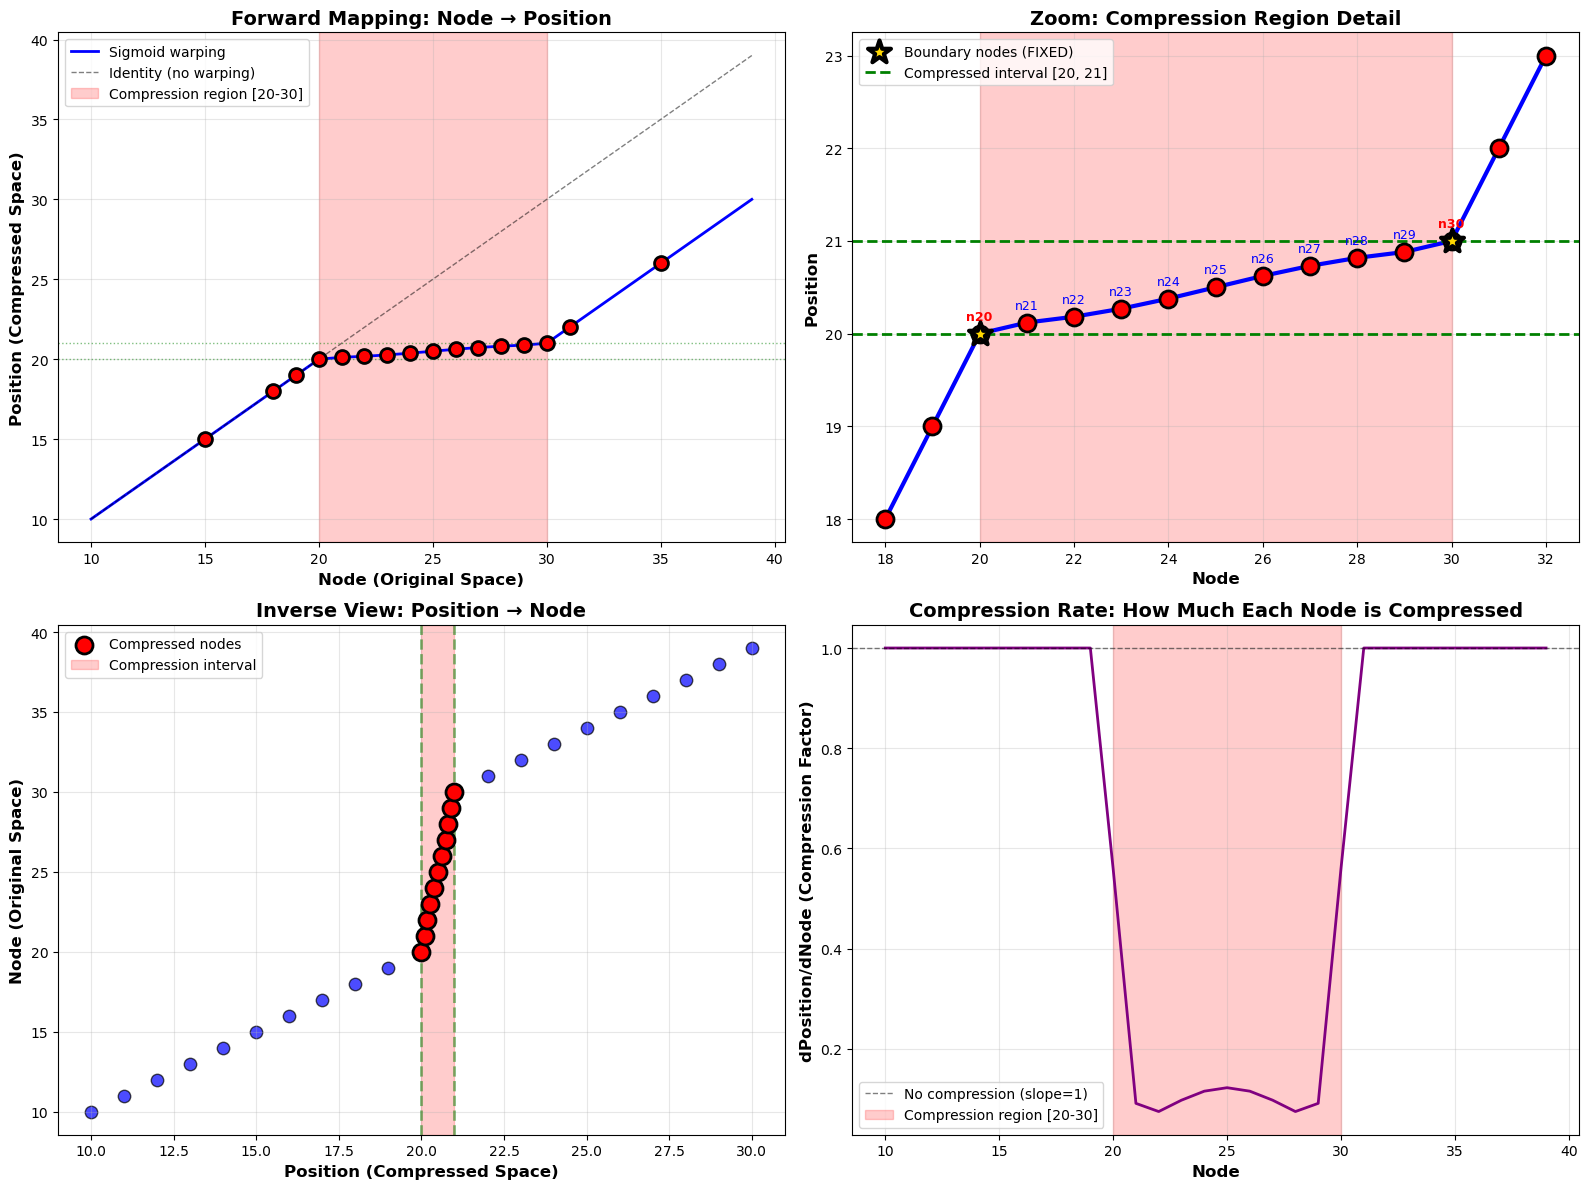


✅ Visualization complete!


In [40]:
# Visualization
print("\n" + "="*80)
print("VISUALIZATION")
print("="*80)

# Sample nodes for visualization
nodes_viz = np.arange(10, 40)
positions_viz = warping.forward(nodes_viz)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Node → Position mapping
ax = axes[0, 0]
ax.plot(nodes_viz, positions_viz, 'b-', linewidth=2, label='Sigmoid warping')
ax.plot(nodes_viz, nodes_viz, 'k--', linewidth=1, alpha=0.5, label='Identity (no warping)')

# Highlight compression region (now includes node 30!)
ax.axvspan(20, 30, alpha=0.2, color='red', label='Compression region [20-30]')
ax.axhline(20, color='green', linestyle=':', alpha=0.5, linewidth=1)
ax.axhline(21, color='green', linestyle=':', alpha=0.5, linewidth=1)

# Mark discrete nodes
ax.scatter(test_nodes, warping.forward(test_nodes), c='red', s=100, zorder=5, edgecolors='black', linewidth=2)

ax.set_xlabel('Node (Original Space)', fontsize=12, fontweight='bold')
ax.set_ylabel('Position (Compressed Space)', fontsize=12, fontweight='bold')
ax.set_title('Forward Mapping: Node → Position', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Zoom on compression region
ax = axes[0, 1]
nodes_zoom = np.arange(18, 33)
positions_zoom = warping.forward(nodes_zoom)

ax.plot(nodes_zoom, positions_zoom, 'b-', linewidth=3)
ax.scatter(nodes_zoom, positions_zoom, c='red', s=150, zorder=5, edgecolors='black', linewidth=2)

# Highlight boundary nodes
ax.scatter([20, 30], [warping.forward(20), warping.forward(30)], 
          c='gold', s=300, marker='*', zorder=10, edgecolors='black', linewidth=3,
          label='Boundary nodes (FIXED)')

for node in nodes_zoom:
    pos = warping.forward(node)
    if 20 <= node <= 30:
        color = 'red' if node in [20, 30] else 'blue'
        weight = 'bold' if node in [20, 30] else 'normal'
        ax.annotate(f'n{node}', (node, pos), textcoords="offset points", xytext=(0,10), 
                   ha='center', fontsize=9, fontweight=weight, color=color)

ax.axvspan(20, 30, alpha=0.2, color='red')
ax.axhline(20, color='green', linestyle='--', linewidth=2, label='Compressed interval [20, 21]')
ax.axhline(21, color='green', linestyle='--', linewidth=2)

ax.set_xlabel('Node', fontsize=12, fontweight='bold')
ax.set_ylabel('Position', fontsize=12, fontweight='bold')
ax.set_title('Zoom: Compression Region Detail', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Position distribution (histogram-style)
ax = axes[1, 0]
ax.scatter(positions_viz, nodes_viz, c='blue', s=80, alpha=0.7, edgecolors='black', linewidth=1)

# Highlight compressed nodes (now including node 30!)
compressed_mask = (nodes_viz >= 20) & (nodes_viz <= 30)
ax.scatter(positions_viz[compressed_mask], nodes_viz[compressed_mask], 
          c='red', s=150, zorder=5, edgecolors='black', linewidth=2, label='Compressed nodes')

ax.axvline(20, color='green', linestyle='--', linewidth=2, alpha=0.5)
ax.axvline(21, color='green', linestyle='--', linewidth=2, alpha=0.5)
ax.axvspan(20, 21, alpha=0.2, color='red', label='Compression interval')

ax.set_xlabel('Position (Compressed Space)', fontsize=12, fontweight='bold')
ax.set_ylabel('Node (Original Space)', fontsize=12, fontweight='bold')
ax.set_title('Inverse View: Position → Node', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Derivative (how much compression at each point)
ax = axes[1, 1]
# Numerical derivative: dPosition/dNode
dpos_dnode = np.gradient(positions_viz, nodes_viz)

ax.plot(nodes_viz, dpos_dnode, 'purple', linewidth=2)
ax.axhline(1.0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='No compression (slope=1)')
ax.axvspan(20, 30, alpha=0.2, color='red', label='Compression region [20-30]')

ax.set_xlabel('Node', fontsize=12, fontweight='bold')
ax.set_ylabel('dPosition/dNode (Compression Factor)', fontsize=12, fontweight='bold')
ax.set_title('Compression Rate: How Much Each Node is Compressed', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Visualization complete!")


## 🧪 Example 2: No Compression (Length = 1)


In [41]:
# Example 2: No compression (length = 1)
print("="*80)
print("EXAMPLE 2: No Compression - Length = 1 at Node 20")
print("="*80)

warping_no_compress = SigmoidWarping(node_index=20, length=1)

print("\n📊 Forward mapping:")
test_simple = [18, 19, 20, 21, 22]
for node in test_simple:
    pos = warping_no_compress.forward(node)
    print(f"   Node {node} → Position {pos}")

print("\n💡 With length=1, node 20 maps to itself, no shift occurs!")
print(f"   This is identity mapping (no warping effect)")


EXAMPLE 2: No Compression - Length = 1 at Node 20
📊 Sigmoid Warping Created:
   Start node: 20
   End node: 21
   Length: 1 (distance from 20 to 21)
   Total nodes: 2 nodes [20, 21, ..., 21]
   Compressed to: [20, 21] (unit length)
   Boundary fixed: node 20 → 20.0, node 21 → 21.0
   Inner nodes (0 nodes): Sigmoid mapping
   Nodes after 21: Shift left by 0 units
   Steepness: 5.0

📊 Forward mapping:
   Node 18 → Position 18.0
   Node 19 → Position 19.0
   Node 20 → Position 20.0
   Node 21 → Position 21.0
   Node 22 → Position 22.0

💡 With length=1, node 20 maps to itself, no shift occurs!
   This is identity mapping (no warping effect)


## 🌐 Example 3: Infinite Domain Test


In [42]:
# Example 3: Infinite domain - test extreme values
print("="*80)
print("EXAMPLE 3: Testing Infinite Domain Support")
print("="*80)

# Use the original warping (node 20, length 10)
print("\n📊 Testing extreme node values:\n")
print(f"{'Node':<15} | {'Position':<15} | {'Round-trip Node':<17} | {'Status'}")
print(f"{'-'*15}|{'-'*17}|{'-'*19}|{'-'*15}")

extreme_nodes = [-1000, -100, -10, 0, 10, 20, 25, 29, 30, 50, 100, 1000, 10000]

for node in extreme_nodes:
    pos = warping.forward(node)
    recovered = warping.inverse(pos)
    status = "✅" if recovered == node else "❌"
    print(f"{node:<15} | {pos:<15.3f} | {recovered:<19} | {status}")

print("\n💡 Works on infinite domain!")
print("   - Negative nodes: ✅")
print("   - Very large positive nodes: ✅")
print("   - All nodes perfectly recoverable: ✅")
print("\n   This means the optimizer can explore anywhere in (-∞, +∞)!")


EXAMPLE 3: Testing Infinite Domain Support

📊 Testing extreme node values:

Node            | Position        | Round-trip Node   | Status
---------------|-----------------|-------------------|---------------
-1000           | -1000.000       | -1000               | ✅
-100            | -100.000        | -100                | ✅
-10             | -10.000         | -10                 | ✅
0               | 0.000           | 0                   | ✅
10              | 10.000          | 10                  | ✅
20              | 20.000          | 20                  | ✅
25              | 20.500          | 25                  | ✅
29              | 20.881          | 29                  | ✅
30              | 21.000          | 30                  | ✅
50              | 41.000          | 50                  | ✅
100             | 91.000          | 100                 | ✅
1000            | 991.000         | 1000                | ✅
10000           | 9991.000        | 10000               | ✅

💡 Works on

---

## 📊 Summary: What We Built

### ✅ Complete Sigmoid-Based Warping System

**Metadata-driven**:
```python
SigmoidWarping(node_index=20, length=10)
```
- Stores: which node, how many nodes to compress
- Simple, clear specification

**Forward mapping**: `Node (int) → Position (float)`
- Identity before compression
- Smooth sigmoid compression in target region  
- Shifted identity after compression

**Inverse mapping**: `Position (float) → Node (int)`
- Exact recovery of integer node
- Perfect reversibility

**Infinite domain**: Works on (-∞, +∞)
- No extrapolation issues (unlike CNF!)
- Natural behavior everywhere

---

## 🎯 Comparison: Analytical vs CNF

| Feature | Analytical (This) | CNF (Previous) |
|---------|-------------------|----------------|
| **Specification** | Metadata: (node, length) | Training data |
| **Training** | None needed | Minutes of training |
| **Speed** | Instant (μs) | Slow (ms) |
| **Accuracy** | Perfect (exact) | Approximate |
| **Reversibility** | Perfect | Approximate |
| **Infinite domain** | Natural | Needs hybrid fix |
| **Complexity** | ~100 lines | ~1000+ lines |
| **Interpretable** | Yes (explicit formula) | No (black box) |

**Result**: Analytical is MUCH better for this use case! ✅

---

## 🚀 What This Enables

### For Optimization:

1. **Compress problematic regions** with local optima
2. **Optimizer takes larger steps** in compressed space
3. **Can escape local optima** efficiently
4. **Works on infinite domain** - no boundaries!
5. **Fast** - no overhead for real-time optimization

### Next Steps:

- Integrate with optimizer (hill climbing, PSO, etc.)
- Test on multi-modal benchmarks (Rastrigin, Ackley, etc.)
- Adaptive selection of regions to compress
- Cascaded compression for complex landscapes


## 💻 Complete Usage Example


---

## ✅ CORRECTED IMPLEMENTATION

### What was fixed:

**Previous (WRONG)**:
- `(20, 10)` meant: 10 nodes starting at 20 → [20, 21, ..., 29]
- All nodes used sigmoid mapping

**Current (CORRECT)**:
- `(20, 10)` means: length 10 from node 20 → [20, 21, ..., 30] (**11 nodes**)
- **Boundary nodes FIXED**:
  - Node 20 → exactly 20.0 (left boundary)
  - Node 30 → exactly 21.0 (right boundary)
- **Inner nodes** (21-29): Use sigmoid for smooth distribution

### Why boundaries are fixed:

1. **No interpolation error** at boundaries
2. **Perfect alignment** with adjacent regions
3. **Mathematically cleaner**: sigmoid(0) = 0, sigmoid(1) = 1
4. **Better for cascaded compression**: boundaries match exactly

### The formula:

```python
For node n in [20, 30]:
    if n == 20:  position = 20.0  # Left boundary (fixed)
    if n == 30:  position = 21.0  # Right boundary (fixed)
    else:        position = 20 + sigmoid((n-20)/10)  # Inner nodes
```

This is **exactly what you described**! 🎯


In [43]:
# Complete usage example
print("="*80)
print("COMPLETE USAGE EXAMPLE")
print("="*80)

# Step 1: Create warping with metadata
print("\n✅ Step 1: Create warping")
print("   Compress 10 nodes starting at node 20")
my_warping = SigmoidWarping(node_index=20, length=10, steepness=5.0)

# Step 2: Get metadata
print("\n✅ Step 2: Access metadata")
info = my_warping.get_info()
print(f"   Metadata: {info}")

# Step 3: Map nodes to positions (for optimizer)
print("\n✅ Step 3: Forward mapping (Node → Position)")
nodes = [15, 20, 25, 30, 35]
positions = [my_warping.forward(n) for n in nodes]
for n, p in zip(nodes, positions):
    print(f"   Node {n:3d} → Position {p:6.3f}")

# Step 4: Map positions back to nodes (for evaluation)
print("\n✅ Step 4: Inverse mapping (Position → Node)")
test_positions = [15.0, 20.5, 21.0, 25.0]
for pos in test_positions:
    node = my_warping.inverse(pos)
    print(f"   Position {pos:6.3f} → Node {node:3d}")

# Step 5: Verify reversibility
print("\n✅ Step 5: Verify reversibility")
test_node = 25
pos = my_warping.forward(test_node)
recovered = my_warping.inverse(pos)
print(f"   Original node: {test_node}")
print(f"   → Position: {pos:.6f}")
print(f"   → Recovered: {recovered}")
print(f"   → Match: {'✅' if test_node == recovered else '❌'}")

print("\n" + "="*80)
print("🎉 Ready to use for optimization!")
print("="*80)


COMPLETE USAGE EXAMPLE

✅ Step 1: Create warping
   Compress 10 nodes starting at node 20
📊 Sigmoid Warping Created:
   Start node: 20
   End node: 30
   Length: 10 (distance from 20 to 30)
   Total nodes: 11 nodes [20, 21, ..., 30]
   Compressed to: [20, 21] (unit length)
   Boundary fixed: node 20 → 20.0, node 30 → 21.0
   Inner nodes (9 nodes): Sigmoid mapping
   Nodes after 30: Shift left by 9 units
   Steepness: 5.0

✅ Step 2: Access metadata
   Metadata: {'node_start': 20, 'node_end': 30, 'length': 10, 'shift': 9, 'steepness': 5.0, 'compressed_interval': (20, 21.0)}

✅ Step 3: Forward mapping (Node → Position)
   Node  15 → Position 15.000
   Node  20 → Position 20.000
   Node  25 → Position 20.500
   Node  30 → Position 21.000
   Node  35 → Position 26.000

✅ Step 4: Inverse mapping (Position → Node)
   Position 15.000 → Node  15
   Position 20.500 → Node  25
   Position 21.000 → Node  30
   Position 25.000 → Node  34

✅ Step 5: Verify reversibility
   Original node: 25
   → Pos